# EJEMPLO DE FINE-TUNING DE BERT PARA CLASIFICACIÓN DE TEXTOS

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/NLP-course/Toxicity/Data/'

In [1]:
path = 'data/'

Estos datos los puedes descargar de:

https://krono.act.uji.es/NLP-course/jigsaw-toxic-comment-classification-challenge.zip

# Inicio

In [3]:
!pip install tensorflow_hub

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf

import os
import sys

import tensorflow_hub as hub
from tensorflow.keras.models import Model 


# Cargamos el Conjunto de Datos

In [3]:
df =  pd.read_csv(path + 'train.csv') 
df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [4]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Cosas de BERT

In [5]:
from keras.utils import plot_model

In [8]:
!test -d models || git clone https://github.com/tensorflow/models models

^C


In [9]:
if not '/content/models/official/nlp/bert' in sys.path:
  sys.path += ['/content/models/official/nlp/bert']

In [6]:
!pip install sentencepiece

In [23]:
!pip install bert-tensorflow==1.0.1

In [24]:
from bert import tokenization

In [8]:
# See BERT paper: https://arxiv.org/pdf/1810.04805.pdf
# And BERT implementation convert_single_example() at https://github.com/google-research/bert/blob/master/run_classifier.py

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

Conceptos introductorios de  **BERT** (Se puede saltar)

In [9]:
max_seq_length = 128  # Máxima longitud de las cadenas (palabras)

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 108310273   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

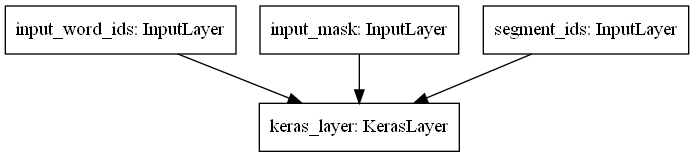

In [10]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
model.summary()

plot_model(model)

In [25]:
vocab_file     = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case  = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer      = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [26]:
s = "This is a nice sentence."
tokens = tokenizer.tokenize(s)
print(tokens)

UnparsedFlagAccessError: Trying to access flag --preserve_unused_tokens before flags were parsed.

In [ ]:
#TOKENS especiales [CLS] [SEP] [MASK]

stokens = ["[CLS]"] + tokens + ["[SEP]"]

In [ ]:
input_ids = get_ids(stokens, tokenizer, max_seq_length)
input_masks = get_masks(stokens, max_seq_length)
input_segments = get_segments(stokens, max_seq_length)

In [ ]:
print(stokens)
print(input_ids)
print(input_masks)
print(input_segments)

['[CLS]', '[CLS]', 'This', 'is', 'a', 'nice', 'sentence', '.', '[SEP]', '[SEP]']
[101, 101, 1188, 1110, 170, 3505, 5650, 119, 102, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
[all_embs, tokens_emb] = model.predict([tf.convert_to_tensor(np.array(input_ids), dtype=tf.int32),
                                        tf.convert_to_tensor(np.array(input_masks), dtype=tf.int32),
                                        tf.convert_to_tensor(np.array(input_segments), dtype=tf.int32)])

print(all_embs.shape)
print(tokens_emb.shape)

(128, 768)

## MODELOS PRE-ENTRENADOS

In [ ]:
BERT_DIR_NAME  = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1"

bert_layer     = hub.KerasLayer(BERT_DIR_NAME, trainable = False, name = "BertLayer") ##OJO No es FINE-TUNING!!!

vocab_file     = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case  = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer      = tokenization.FullTokenizer(vocab_file, do_lower_case)

## PREPARANDO DATOS

In [ ]:
input_ids_all      = []
input_masks_all    = []
input_segments_all = []

max_seq_length = 128

def text2bert(s):
  global tokenizer, max_seq_length,input_ids_all,input_masks_all,input_segments_all
  
  if s==None: s=''
  
  tokens = tokenizer.tokenize(s)[:max_seq_length - 2]
  stokens = ["[CLS]"] + tokens + ["[SEP]"]

  input_ids_all.append(get_ids(stokens, tokenizer, max_seq_length))
  input_masks_all.append(get_masks(stokens, max_seq_length))
  input_segments_all.append(get_segments(stokens, max_seq_length))
  
  return len(tokens) - max_seq_length - 2

In [ ]:
#df2 = df.iloc[:5000]
df['comment_text'].apply(text2bert)

classes = df['toxic'] #multiclass -> vectors of 6 units np.array(...)
classes.describe()

print(df.iloc[:5]['comment_text'], df.iloc[:5]['toxic'])
df.head(5)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object 0    0
1    0
2    0
3    0
4    0
Name: toxic, dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## ENTRENAMIENTO

Construimos el modelo mediante el API funcional de TF. Básicamente añadimos dos capas densas por encima de la capa de BERT.

In [ ]:
def build_model_(max_seq_length, bert_layer):
  
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
  input_mask     = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_mask")
  segment_ids    = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="segment_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  dense = tf.keras.layers.Dense(256, activation='relu', name = 'dense1')( pooled_output )
  pred  = tf.keras.layers.Dense(1, activation='sigmoid', name = 'prediction')(dense) #multiclass -> 6 units

  model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pred])
  #pooled_output, sequence_output

  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  #plot_model(model) ##doesn't work!
  
  return model

In [ ]:
model = build_model_(max_seq_length, bert_layer)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BertLayer (KerasLayer)          [(None, 768), (None, 108310273   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) ##loss -> crossentropy


In [ ]:
model.fit(
    [  np.array(input_ids_all),  np.array(input_masks_all), np.array(input_segments_all) ],
    np.array(classes),
    validation_split = 0.3,
    epochs = 1,             ##cambiar!!
    batch_size = 50
)

 492/2234 [=====>........................] - ETA: 21:26 - loss: 0.3300 - accuracy: 0.8988

**También puede hacerse de la siguiente forma**

ids_tensors = tf.constant(input_ids_all)

mask_tensors = tf.constant(input_masks_all)

segments_tensors = tf.constant(input_segments_all)


model_Bert_all.predict(
    [ ids_tensors,  mask_tensors, segments_tensors ] )


## PREDICCIONES

In [ ]:
def predict(sentences):
  global tokenizer, max_seq_length, model

  all_ids, all_msk, all_sgm = [],[],[]

  for s in sentences:
    if s==None: s=''

    stokens = tokenizer.tokenize(s)[:max_seq_length - 2]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    input_ids  = get_ids(stokens, tokenizer, max_seq_length)
    input_msk  = get_masks(stokens, max_seq_length)
    input_sgm  = get_segments(stokens, max_seq_length)

    all_ids.append(tf.convert_to_tensor(np.array(input_ids), dtype=tf.int32))
    all_msk.append(tf.convert_to_tensor(np.array(input_msk), dtype=tf.int32))
    all_sgm.append(tf.convert_to_tensor(np.array(input_sgm), dtype=tf.int32))

  return model.predict([all_ids,all_msk,all_sgm])

In [ ]:
predict(["Fuck off! go to hell!","this is very nice","he is the cancer and the metastasis","you son of a bitch!","my cat is cute"])

array([[0.9412036 ],
       [0.01432279],
       [0.18587193],
       [0.95242214],
       [0.3192857 ]], dtype=float32)

# VALIDACIÓN

In [ ]:
dftest =  pd.read_csv(path + 'test.csv') 
dftest.head(1)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...


In [ ]:
dftest.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,eeb3f6e39bf33b62,""" \n :Your submission is still in your sandbox..."
freq,1,1


In [ ]:
dflabels = pd.read_csv(path + 'test_labels.csv')
dflabels.head(1)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1


In [ ]:
dfall = pd.merge(dftest, dflabels, on='id', how='inner')
dfall.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,-1,-1,-1,-1,-1,-1


In [ ]:
prueba = dfall['comment_text'][:100]

In [ ]:
outcomes = predict(prueba)

In [ ]:
test_clases = dfall['toxic'][:100]
for row in zip(outcomes[:100],test_clases[:100],prueba):
  print('%0.4f'%row[0][0], '%2s'%row[1], row[2][:90].replace('\n',' ').replace('\r',' '))

0.8788 -1 Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sa
0.0149 -1 == From RfC ==    The title is fine as it is, IMO.
0.0016 -1 "    == Sources ==    * Zawe Ashton on Lapland —  /  "
0.0005 -1 :If you have a look back at the source, the information I updated was the correct form. I 
0.0694 -1 I don't anonymously edit articles at all.
0.0010  0 Thank you for understanding. I think very highly of you and would not revert without discu
0.0016 -1 Please do not add nonsense to Wikipedia. Such edits are considered vandalism and quickly u
0.4528  0 :Dear god this site is horrible.
0.0221 -1 "   Only a fool can believe in such numbers.   The correct number lies between 10 000 to 1
0.1226 -1 == Double Redirects ==    When fixing double redirects, don't just blank the outer one, yo
0.1322 -1 I think its crap that the link to roggenbier is to this article. Somebody that knows how t
0.0577  0 "::: Somebody will invariably try to add Religion?  Really??  

In [ ]:
predict(["ted therapy proves its worth in metastatic kidney cancer patients : a new study looked at targeted"])

array([[0.00301533]], dtype=float32)

In [ ]:
predict(["guess which bitch thought she had brain tumor but turns out having a normal migraine"])

array([[0.33499599]], dtype=float32)

In [ ]:
predict(["it pathetic how people are on roman's ass because hewon an award . {ret} {ret} he beat leukemia , you fucking assholes . {lnk}"])

array([[0.87012327]], dtype=float32)

In [ ]:
predict(["you're a fucking malignant tumor and i'm ashamed to be from the same country as your fat bloviated ass that thinks like a pattern"])

array([[0.9289741],
       [0.8996341]], dtype=float32)